In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [267]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sp_ca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sp_ca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sp_ca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [268]:
# Read in dataset as dataframe
cases_df = pd.read_excel("cases.xlsm")

In [269]:
# Explore the basic data structure
print(cases_df.head())
print("\n")
print(cases_df.info())
print("\n")

# Check for null values
print('----------Null values----------')
print(cases_df.isnull().values.any())

                                         description  \
0  Reckitt Benckiser (Australia) televised a misl...   
1  Australia TGA: Wise Feet Foot Patches internet...   
2  TGA: Multi-level marketing company (The Juice ...   
3  TGA: Carusos Natural Health fined $12,600 for ...   
4  TGA: TGA has issued 12 infringement notices fo...   

                                             issue  
0  Advertisement non-compliance (prohibited claim)  
1  Advertisement non-compliance (prohibited claim)  
2  Advertisement non-compliance (prohibited claim)  
3  Advertisement non-compliance (prohibited claim)  
4  Advertisement non-compliance (prohibited claim)  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  2421 non-null   object
 1   issue        2421 non-null   object
dtypes: object(2)
memory usage: 38.0+ KB
None


----------Null values----

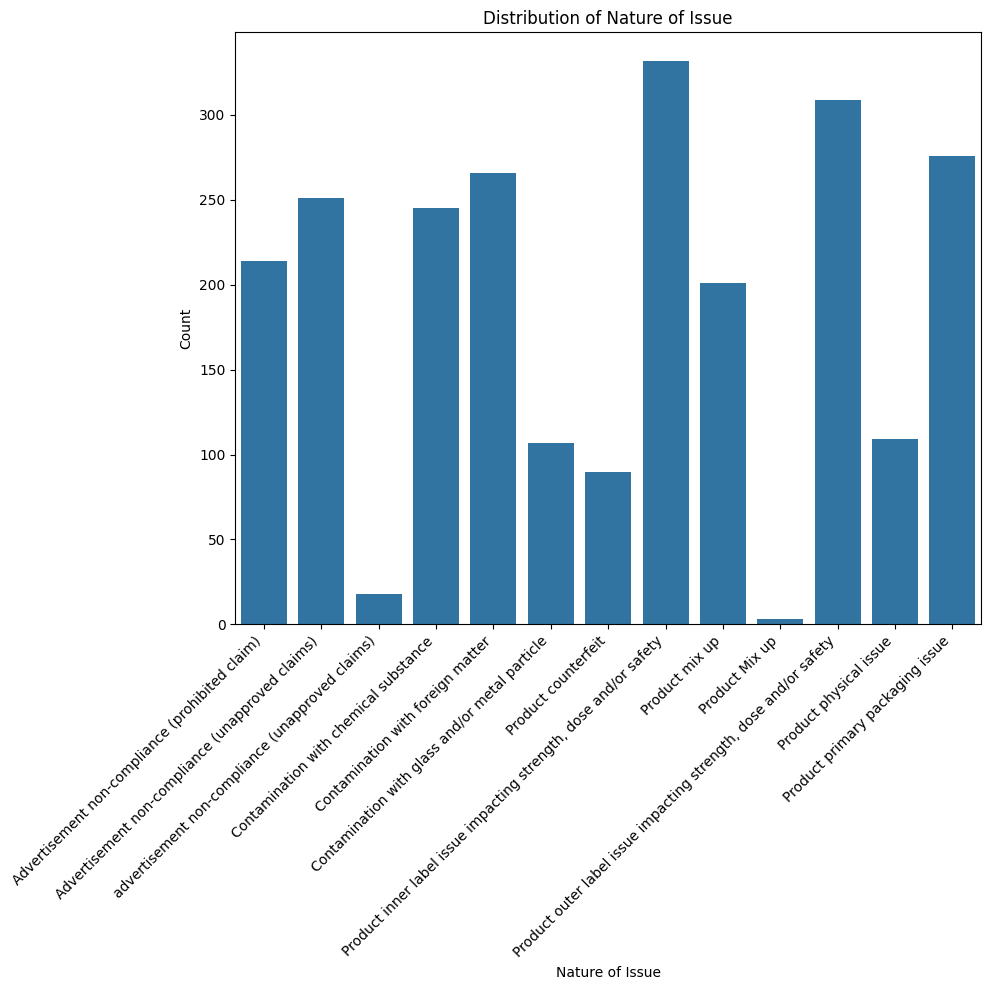

In [270]:
# Distribution of Target Variable
plt.figure(figsize=(10, 10))
sns.countplot(x='issue', data=cases_df)
plt.title('Distribution of Nature of Issue')
plt.xlabel('Nature of Issue')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

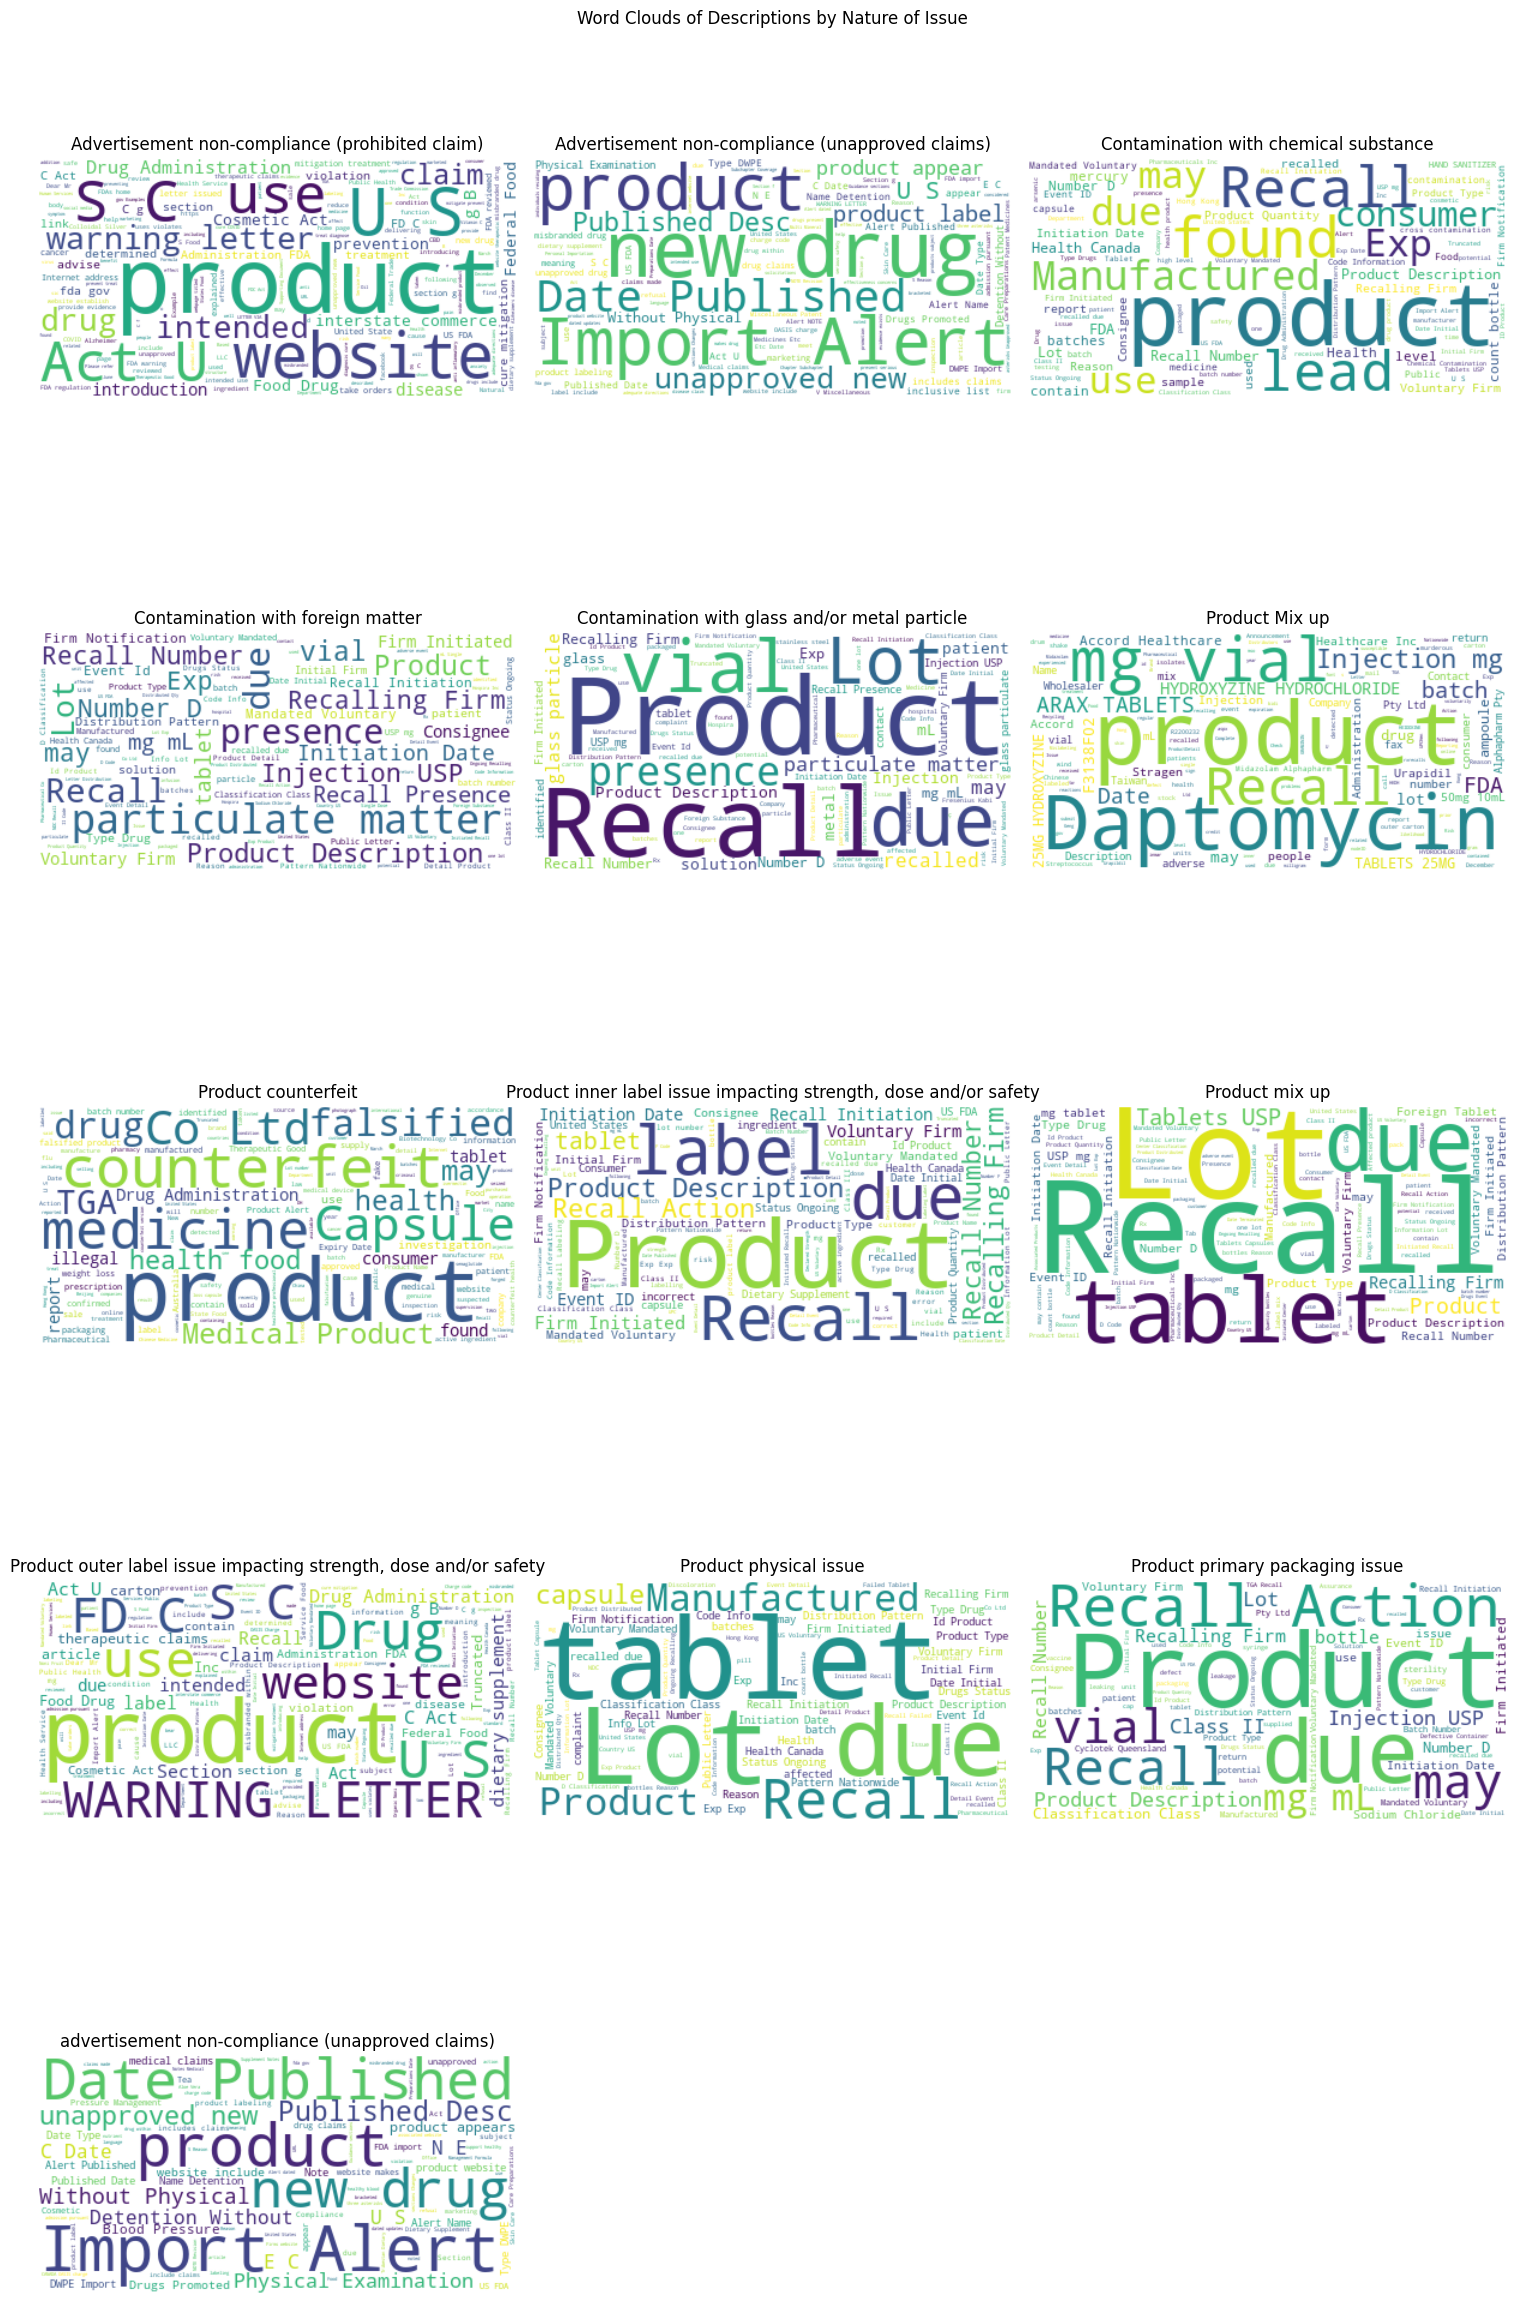

In [271]:
# Generate word cloud for each nature of issue to understand what words are most repeated
unique_issues = cases_df['issue'].unique()
num_issues = len(unique_issues)
num_rows = (num_issues + 2) // 3 
num_cols = min(num_issues, 3)

plt.figure(figsize=(15, 5 * num_rows))

# Group by nature of issue and iterate over each group
for i, (issue, group) in enumerate(cases_df.groupby('issue')):
    
    descriptions = ' '.join(group['description'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(descriptions)
    
    # Plot word cloud for each issue
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(issue)
    plt.axis('off')

plt.suptitle('Word Clouds of Descriptions by Nature of Issue')
plt.tight_layout()
plt.show()

Preprocessing of sentences

In [272]:
stop_words = set(stopwords.words("english")) # Defining stopwords to remove
lemmatizer = WordNetLemmatizer()

In [273]:
# Convert 'issues' column to lowercase (I noticed some issues were mis-labelled when training)
cases_df['issue'] = cases_df['issue'].str.lower()

In [274]:
def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()

    # Tokenize text into individual words
    words = nltk.word_tokenize(text)
    
    # Lemmatize words and remove stopwords
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join lemmatized words back into a single sentence
    preprocessed_text = ' '.join(lemmatized_words)
    return preprocessed_text

# Add the preprocessed description column to the df
cases_df['preprocessed_description'] = cases_df['description'].apply(preprocess_text)

In [275]:
print(cases_df.head())

                                         description  \
0  Reckitt Benckiser (Australia) televised a misl...   
1  Australia TGA: Wise Feet Foot Patches internet...   
2  TGA: Multi-level marketing company (The Juice ...   
3  TGA: Carusos Natural Health fined $12,600 for ...   
4  TGA: TGA has issued 12 infringement notices fo...   

                                             issue  \
0  advertisement non-compliance (prohibited claim)   
1  advertisement non-compliance (prohibited claim)   
2  advertisement non-compliance (prohibited claim)   
3  advertisement non-compliance (prohibited claim)   
4  advertisement non-compliance (prohibited claim)   

                            preprocessed_description  
0  reckitt benckiser australia televised misleadi...  
1  australia tga wise foot foot patch internet ad...  
2  tga multi level marketing company juice plus c...  
3  tga caruso natural health fined falsely claimi...  
4  tga tga issued infringement notice alleged unl...  


In [276]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [277]:
# Preprocessed text data is available in "preprocessed_description"
X = cases_df['preprocessed_description']
y = cases_df['issue']

In [278]:
# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X)

I chose TF-IDF as I think it's the better model here. Bag-of-Words embedding does not specifically consider the importance of some words, while TF-IDF considers the importance of words across the entire dataset. It gives higher weights to words that are frequent in a sentence but otherwise rare in the dataset.

In [279]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Method 1: Logistic Regression**

In [280]:
# Any classification algorithm (e.g., Logistic Regression)
classifier = LogisticRegression(max_iter=1000)

In [281]:
# Training classifier
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [282]:
# Evaluate the chosen model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6350515463917525
Classification Report:
                                                                  precision    recall  f1-score   support

                 advertisement non-compliance (prohibited claim)       0.64      0.90      0.75        41
                advertisement non-compliance (unapproved claims)       0.88      0.82      0.85        65
                           contamination with chemical substance       0.80      0.67      0.73        48
                               contamination with foreign matter       0.60      0.71      0.65        49
                  contamination with glass and/or metal particle       0.50      0.05      0.09        21
                                             product counterfeit       0.93      0.88      0.90        16
product inner label issue impacting strength, dose and/or safety       0.49      0.70      0.58        67
                                                  product mix up       0.39      0.61      0.48    

**Method 2: Random Forest**

In [283]:
# Preprocessed text data is available in "preprocessed_description"
X = cases_df['preprocessed_description']
y = cases_df['issue']

In [284]:
# Convert text data into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X)

In [285]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [286]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [287]:
print("Random Forest Classifier:")
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier:
Accuracy: 0.643298969072165
Classification Report:
                                                                  precision    recall  f1-score   support

                 advertisement non-compliance (prohibited claim)       0.63      0.73      0.67        44
                advertisement non-compliance (unapproved claims)       0.84      0.84      0.84        55
                           contamination with chemical substance       0.79      0.80      0.80        46
                               contamination with foreign matter       0.57      0.75      0.65        56
                  contamination with glass and/or metal particle       1.00      0.05      0.09        21
                                             product counterfeit       0.88      0.78      0.82        18
product inner label issue impacting strength, dose and/or safety       0.50      0.77      0.61        56
                                                  product mix up       0.4

**XGBoosting**

In [288]:
import xgboost as xgb

X = cases_df['preprocessed_description']
y = cases_df['issue']

In [289]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X)

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [291]:
# Encode the data as XGBoost needs numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=11, random_state=42)
xgb_classifier.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=11,
              num_parallel_tree=None, ...)

In [292]:
# Similarly encode the testing labels
y_test_encoded = label_encoder.transform(y_test)

y_pred_xgb_encoded = xgb_classifier.predict(X_test)

# Decode the encoded labels back to their original string labels
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb_encoded)

# Calculate accuracy
accuracy_xgb_encoded = accuracy_score(y_test_encoded, y_pred_xgb_encoded)
print("XGBoost Classifier Accuracy", accuracy_xgb_encoded)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_xgb_decoded))
print("Confusion Matrix:")
print(confusion_matrix(y_test_decoded, y_pred_xgb_decoded))


XGBoost Classifier Accuracy 0.7505154639175258
Classification Report:
                                                                  precision    recall  f1-score   support

                 advertisement non-compliance (prohibited claim)       0.85      0.83      0.84        41
                advertisement non-compliance (unapproved claims)       0.91      0.97      0.94        65
                           contamination with chemical substance       0.80      0.77      0.79        48
                               contamination with foreign matter       0.85      0.69      0.76        49
                  contamination with glass and/or metal particle       0.65      0.71      0.68        21
                                             product counterfeit       0.94      0.94      0.94        16
product inner label issue impacting strength, dose and/or safety       0.56      0.73      0.63        67
                                                  product mix up       0.62      

*Performance metrics, and explanation of which metric was optimised for and why*

The metric I optimised for was the f1-score, ie the weighted score that takes both precision and recall into consideration. I aimed for a model that was able to produce an accuracy score of about 65% and higher in every single label, rather than having a model that may perform very well in 1 label, but particularly poorly in another. Hence, I chose XGBoost, as Logistic regression and Random Forest don't do very well in glass and physical issues.


![LogRegression](img/Logregression_score.png)


![RandomForestScore](img/Random_forest.png)

**In comparison, XGBoost performs averagely well in all labels, thus I evaluate it as the best model in this particular case**
![XGBoostScore](img/XGBoost_score.png)

*I tried performing further hyperparameter tuning with gridsearch, but my laptop is very old so it takes 2+hrs just to run an iteration, so it wasn't feasible*

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distributions for Randomized Search
param_dist = {
    'learning_rate': uniform(0.05, 0.25),
    'max_depth': randint(3,10,2),
    'min_child_weight': randint(1, 5),
    'gamma': uniform(0, 0.4),
    'colsample_bytree': uniform(0.6, 0.9)
}

# Create XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=11, random_state=42)

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist, 
                                   n_iter=30, cv=3, scoring='f1_weighted', random_state=42)
random_search.fit(X_train, y_train_encoded)

# Print best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Predict using the best model found by Randomized Search
y_pred_random = random_search.predict(X_test)

# Decode the predicted labels back to their original string labels
y_pred_decoded_random = label_encoder.inverse_transform(y_pred_random)

# Calculate accuracy
accuracy_random = accuracy_score(y_test_decoded, y_pred_decoded_random)
print("Accuracy after Randomized Search:", accuracy_random)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded_random))
print("Confusion Matrix:")
print(confusion_matrix(y_test_decoded, y_pred_decoded_random))


KeyboardInterrupt: 